<a href="https://colab.research.google.com/github/Witcape/3D_Printing/blob/main/CNN_SRCNN_FINAL_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
train_dir = "/content/drive/MyDrive/Final_Cropped/Train"
test_dir = "/content/drive/MyDrive/Final_Cropped/Test"

# List all image paths and corresponding labels
image_paths = []
labels = []

for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)

    if not os.path.isdir(class_path):
        continue

    for img in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, img))
        labels.append(class_dir)  # Use the directory name as the label

# Split into train and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)


In [13]:
unique_labels = set(labels)
unique_labels
import pandas as pd

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
# Create DataFrame for training data
train_df = pd.DataFrame({
    "filepath": train_paths,
    "class": train_labels
})

# Create DataFrame for validation data
val_df = pd.DataFrame({
    "filepath": val_paths,
    "class": val_labels
})



val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="class",
    target_size=(299, 299),  # Image size for InceptionV3
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="class",
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 846 validated image filenames belonging to 3 classes.
Found 211 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


Found 128 images belonging to 3 classes.


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Define the CNN model
model = Sequential()

# Convolutional Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(299, 299, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 4
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Regularization
model.add(Dense(3, activation='softmax'))  # Output layer for 3 classes

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 299, 299, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 299, 299, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 149, 149, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 149, 149, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 149, 149, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 74, 74, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 74, 74, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 489,411 (1.87 MB)

 Trainable params: 488,451 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [16]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 567s 16s/step - accuracy: 0.3690 - loss: 1.4415 - val_accuracy: 0.3602 - val_loss: 1.0832
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 620ms/step - accuracy: 0.4266 - loss: 1.1536 - val_accuracy: 0.3507 - val_loss: 1.1141
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 675ms/step - accuracy: 0.4660 - loss: 1.0645 - val_accuracy: 0.3460 - val_loss: 1.1187
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 658ms/step - accuracy: 0.5165 - loss: 0.9587 - val_accuracy: 0.2607 - val_loss: 1.1604
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 642ms/step - accuracy: 0.5474 - loss: 0.9199 - val_accuracy: 0.3886 - val_loss: 1.1362
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 677ms/step - accuracy: 0.5846 - loss: 0.8943 - val_accuracy: 0.4028 - val_loss: 1.1101
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 656ms/step - accuracy: 0.6110 - loss: 0.8493 - val_accuracy: 0.3791 - val_loss: 1.0504
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 625ms/step - accuracy: 0.6070 - loss: 0.8434 - val_accuracy: 0.3791

In [17]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 15s/step - accuracy: 0.6938 - loss: 0.8440
Test Accuracy: 0.7891


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.50      0.67        42
   Spaghetti       0.84      0.86      0.85        42
   Stringing       0.69      1.00      0.81        44

    accuracy                           0.79       128
   macro avg       0.84      0.79      0.78       128
weighted avg       0.84      0.79      0.78       128



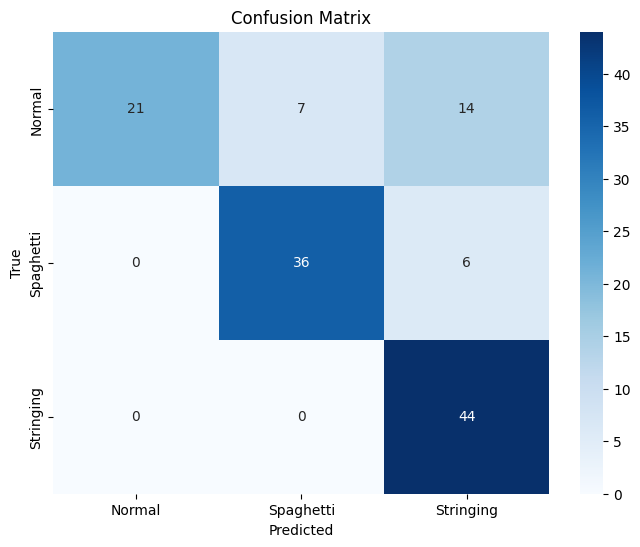

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
test_generator.reset()  # Ensure generator starts from the beginning
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Convert one-hot predictions to class indices
true_classes = test_generator.classes  # True labels from the generator
class_labels = list(test_generator.class_indices.keys())  # Get class labels

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
